In [1]:
import xarray as xr
import numpy as np

from scipy import stats                                                         

import matplotlib.pyplot as plt
import seaborn as sns

import sstats.tseries as ts
import sstats.sigp as sigp
import sstats.hfreq as hf

# dev
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
# https://www.wrighters.io/using-autoreload-to-speed-up-ipython-and-jupyter-work/
%reload_ext autoreload
%autoreload 1
#%aimport sstats
%aimport sstats

In [2]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
#
#
from dask_jobqueue import PBSCluster
#
cluster = PBSCluster(processes=7, cores=7,walltime='02:00:00') #processes=7, cores=7
#
w = cluster.scale(jobs=9)
#
client = Client(cluster)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
root_dir = '/home1/datawork/zcaspar/mit4320/'
#'/Users/zcaspar/codes/mit4320/'
#
file_lf = root_dir+'ds_synthetic_lf.nc'
#'/home1/datawork/zcaspar/mit4320/ds_synthetic_lf.nc'

In [4]:
def generate_filter(band, T=10, dt=1/24, lat=None, bandwidth=None, normalized_bandwidth=None):
    """Wrapper around scipy.signal.firwing
    
    Parameters
    ----------
    band: str, float
        Frequency band (e.g. "semidiurnal", ...) or filter central frequency
    T: float
        Filter length in days
    dt: float
        Filter/time series time step
    lat: float
        Latitude (for inertial band)
    bandwidth: float
        Filter bandwidth in cpd
    dt: float
        hours
    """
    numtaps = int(T*24)    
    pass_zero = False
    #
    if band == "subdiurnal":
        pass_zero = True
        cutoff = [1.0 / 2.0]    
    elif band == "semidiurnal":
        omega = 1.9322 #  M2 24/12.4206012 = 1.9322
    elif band == "diurnal":
        omega = 1. # K1 24/23.93447213 = 1.0027
    elif band == "inertial":
        try:
            omega = coriolis(lat) * 3600 / 2.0 / np.pi
        except:
            print("latitude needs to be provided to generate_filter")
    elif isinstance(band, float):
        omega = band
    #
    if bandwidth is not None:
        cutoff = [omega - bandwidth, omega + bandwidth]
    elif normalized_bandwidth is not None:
        cutoff = [omega * (1 - normalized_bandwidth), 
                  omega * (1.0 + normalized_bandwidth),
                 ]
    elif band != "subdiurnal":
        print("bandwidth or normalized_bandwidth needs to be provided")
    #
    h = signal.firwin(
        numtaps, cutoff=cutoff, pass_zero=pass_zero, fs=1/dt, scale=True
    )
    return h

def filter_response(h, dt=1/24):
    """Returns the frequency response"""
    w, hh = signal.freqz(h, worN=8000, fs=1/dt)
    return hh, w

def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}

In [5]:
def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}



tidal_omega = get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2#center frequency
Tw = 30 #filter length
dband = 0.2 # half-bandwidth

print('omega M2:%s'%omega_M2)
print('omega S2:%s'%omega_S2)
print('omega N2:%s'%omega_N2)
print('omega K2:%s'%omega_K2)

omega M2:1.9322736142672448
omega S2:2.0
omega N2:1.8959819677542018
omega K2:2.0054758185413344


In [6]:
mu=0 # true mean
sigma0 = 1 # true variance
T = 10 # days, decorrelation timescale, base case
dt = 1/24 # hours, sampling interval

#### Filters

In [7]:
import scipy.signal as signal
dband = [0.1,0.2,0.3] #0.05,
h,h_hat,w = {},{},{}
for d in dband:
    h[str(d)] = generate_filter(omega, T=Tw, dt=dt, bandwidth=d, normalized_bandwidth=None)
    h_hat[str(d)], w[str(d)] = filter_response(h[str(d)], dt)

#### Generate and load time series

In [8]:
def generate_timeseries(delta_T, n_draws, T, sigma0, filtering=True, seed=0, chunks=dict(T=-1)):
    u = mu + ts.exp_autocorr((delta_T, dt), T, 
                             np.sqrt(sigma0), 
                             burnin=int(10*T_all[-1]/dt),
                             draws=n_draws,
                             seed=seed,
                             chunks=chunks,
                            )
    ds = u.rename("u").to_dataset()
    # low-pass filter
    if filtering:
        ds["u_bar"] = sigp.filt(ds.u, filter_h)    
    return ds

In [9]:
delta_T = 300 # time series length in days
n_draws = 500 # number of draws
#T_all = [0.1*T, 0.5*T, T,  2*T]
T_all = [0.5*T, T, 2*T, 4*T]
rad = 2*np.pi

In [34]:
ds_low = xr.open_dataset(file_lf).persist()
#ds_hf = xr.open_dataset(root_dir+'ds_synthetic_hf.nc').persist()

ds_low = ds_low.sel(draw=slice(0,n_draws-1))
ds_low

<xarray.Dataset>
Dimensions:  (T: 3, time: 7200, draw: 500, filt: 3)
Coordinates:
  * T        (T) float64 2.0 20.0 200.0
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 299.9 299.9 300.0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * filt     (filt) int64 0 1 2
Data variables:
    u        (filt, T, time, draw) float64 ...
    u_bar    (filt, T, draw, time) float64 ...

In [35]:
ds_low = ds_low.isel(filt=1).rename({'T':'T_low'})

In [36]:
i = 3#,2
ds_hf = {}
for c,om in zip(['M2','S2'],[omega_M2,omega_S2]):
    ds_hf_real = generate_timeseries(delta_T, n_draws, T_all, sigma0, filtering=False,seed=i)
#    ds_hf_imag = generate_timeseries(delta_T, n_draws, T_all, sigma0, filtering=False,seed=j)
#    ds_hf[c] = ((ds_hf_real+1j*ds_hf_imag)/np.sqrt(2)*np.exp(1j*om*rad*ds_hf_real['u'].time)).u
    ds_hf[c] = ds_hf_real*np.exp(1j*om*rad*ds_hf_real['u'].time)
    ds_hf[c] = ds_hf[c].chunk({'time':-1,'draw':-1,'T':-1})
    i+=1
#    j+=2
ds_hf

{'M2': <xarray.Dataset>
 Dimensions:  (T: 4, time: 7200, draw: 500)
 Coordinates:
   * T        (T) float64 5.0 10.0 20.0 40.0
   * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 299.9 299.9 300.0
   * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
 Data variables:
     u        (T, time, draw) complex128 dask.array<chunksize=(4, 7200, 500), meta=np.ndarray>,
 'S2': <xarray.Dataset>
 Dimensions:  (T: 4, time: 7200, draw: 500)
 Coordinates:
   * T        (T) float64 5.0 10.0 20.0 40.0
   * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 299.9 299.9 300.0
   * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
 Data variables:
     u        (T, time, draw) complex128 dask.array<chunksize=(4, 7200, 500), meta=np.ndarray>}

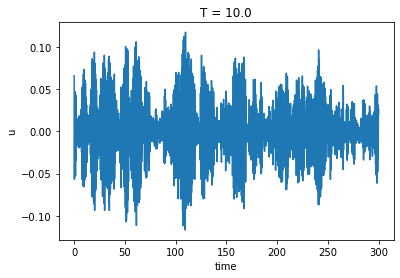

In [13]:
ds_hf['M2'].real.u.sel(T=10).mean('draw').plot()

In [37]:
sigma = [0,0.01,0.1,1.]
for c,om in zip(['M2','S2'],[omega_M2,omega_S2]):
    ds_hf[c] = xr.concat([np.sqrt(u)*ds_hf[c] for u in sigma],dim='rms').assign_coords({'rms':sigma})
    ds_hf[c+'_coh'] = xr.concat([np.sqrt(u)*np.exp(1j*om*rad*ds_hf_real['u'].time
                                                  ) for u in sigma],dim='rms').assign_coords({'rms':sigma})

In [38]:
ds_hf['high_MS'] = ds_hf['M2']+ds_hf['S2']
ds_hf['high_MS_coh'] = ds_hf['M2_coh']+ds_hf['S2_coh']
ds_hf['M2_mix'] = ds_hf['M2']/np.sqrt(2)+ds_hf['M2_coh']/np.sqrt(2) #np.sqrt(2)
ds_hf['S2_mix'] = ds_hf['S2']/np.sqrt(2)+ds_hf['S2_coh']/np.sqrt(2)
ds_hf['high_MS_mix'] = ds_hf['M2_mix']+ds_hf['S2_mix']

In [39]:
for k in ds_hf.keys():
    ds_hf[k] = ds_hf[k].persist()

In [40]:
for _sig in ['','_mix','_coh']:
    ds_hf['total_MS'+_sig] = ds_hf['M2'+_sig]+ds_hf['S2'+_sig]+ds_low.u
    ds_hf['total_M2'+_sig] = ds_hf['M2'+_sig]+ds_low.u

In [41]:
exp_M2_demod = np.exp(-1j*omega_M2*rad*ds_hf['M2'].time)
exp_S2_demod = np.exp(-1j*omega_S2*rad*ds_hf['S2'].time)
exp_MS_demod = np.exp(-1j*omega*rad*ds_hf['S2'].time)

In [42]:
for c in ['M2','S2','high_MS','total_M2','total_MS']:
    ds_hf[c+'_mix'] = ds_hf[c+'_mix'].u
    ds_hf[c] = ds_hf[c].u

In [20]:
ds_M2 = xr.concat([ds_hf['M2'+p] for p in ['_coh','_mix','']], dim='signal'
                 ).assign_coords({'signal':['coherent','mixed','incoherent']}).persist()
ds_S2 = xr.concat([ds_hf['S2'+p] for p in ['_coh','_mix','']], dim='signal'
                 ).assign_coords({'signal':['coherent','mixed','incoherent']}).persist()
ds_MS = xr.concat([ds_hf['high_MS'+p] for p in ['_coh','_mix','']], dim='signal'
                 ).assign_coords({'signal':['coherent','mixed','incoherent']}).persist()


In [43]:
ds_total = xr.merge([xr.concat([ds_hf['total_'+c+p].rename('total_'+c) for p in ['_coh','_mix','']],
               dim='signal').assign_coords({'signal':['coherent','mixed','incoherent']}) for c in ['M2','MS']]).persist()

In [44]:
#ds_M2 = ds_M2.chunk({'time':-1,'draw':-1,'T':-1,'signal':-1})
#ds_S2 = ds_S2.chunk({'time':-1,'draw':-1,'T':-1,'signal':-1})
#ds_MS = ds_MS.chunk({'time':-1,'draw':-1,'T':-1,'signal':-1})
ds_total = ds_total.chunk({'time':-1,'draw':-1,'T':-1,'signal':-1})

In [45]:
ds_total = ds_total.unify_chunks().persist()

In [25]:
ds_filtered_MS = xr.combine_nested([[sigp.bpass_demodulate(xr.Dataset(data_vars = {'MS':ds_MS.sel(signal=p).drop('signal')}
                                                                     ).real,omega,dband,30
                                                 )[0] for dband in [0.1,0.2,0.3]] for p in ['coherent','mixed','incoherent']
                                   ], concat_dim= ['signal','bandwidth']).persist()#.assign_coords({'bandwidth':[0.2,0.4,0.6]})#.persist()
ds_filtered_M2 = xr.combine_nested([[sigp.bpass_demodulate(xr.Dataset(data_vars = {'M2':ds_M2.sel(signal=p).drop('signal')}
                                                                     ).real,omega_M2,dband,30
                                                 )[0] for dband in [0.1,0.2,0.3]] for p in ['coherent','mixed','incoherent']
                                   ], concat_dim= ['signal','bandwidth']).persist()

In [28]:
ds_total

,Array,Chunk
Bytes,79.10 MiB,19.78 MiB
Shape,"(3, 4, 7200, 3, 5, 4)","(3, 1, 7200, 3, 5, 4)"
Count,4 Tasks,4 Chunks
Type,complex128,numpy.ndarray
,Array,Chunk
Bytes,79.10 MiB,19.78 MiB
Shape,"(3, 4, 7200, 3, 5, 4)","(3, 1, 7200, 3, 5, 4)"
Count,4 Tasks,4 Chunks
Type,complex128,numpy.ndarray


In [46]:
ds_filtered_total_MS = xr.combine_nested([[sigp.bpass_demodulate(xr.Dataset(data_vars = {'MS':ds_total.total_MS.sel(signal=p).drop('signal')}
                                                                     ).real,omega,dband,30
                                                 )[0] for dband in [0.1,0.2,0.3]] for p in ['coherent','mixed','incoherent']
                                   ], concat_dim= ['signal','bandwidth']).persist()
ds_filtered_total_M2 = xr.combine_nested([[sigp.bpass_demodulate(xr.Dataset(data_vars = {'M2':ds_total.total_M2.sel(signal=p).drop('signal')}
                                                                     ).real,omega_M2,dband,30
                                                 )[0] for dband in [0.1,0.2,0.3]] for p in ['coherent','mixed','incoherent']
                                   ], concat_dim= ['signal','bandwidth']).persist()

In [47]:
#ds_filtered_M2 = ds_filtered_M2.assign_coords({'bandwidth':[0.2,0.4,0.6],
#                                               'signal':['coherent','mixed','incoherent']})
#ds_filtered_MS = ds_filtered_MS.assign_coords({'bandwidth':[0.2,0.4,0.6],
#                                               'signal':['coherent','mixed','incoherent']})
ds_filtered_total_M2 = ds_filtered_total_M2.assign_coords({'bandwidth':[0.2,0.4,0.6],
                                                           'signal':['coherent','mixed','incoherent']})
ds_filtered_total_MS = ds_filtered_total_MS.assign_coords({'bandwidth':[0.2,0.4,0.6],
                                                           'signal':['coherent','mixed','incoherent']})

In [28]:
ds_filtered_M2 = ds_filtered_M2.compute()
ds_filtered_MS = ds_filtered_MS.compute()

In [48]:
ds_filtered_total_M2 = ds_filtered_total_M2.compute()
#ds_filtered_total_MS = ds_filtered_total_MS.compute()

MemoryError: 

In [49]:
#ds = xr.merge([ds_filtered_M2.rename({'exp':'exp_M2'}),ds_filtered_MS.rename({'exp':'exp_MS'})]) 
ds_total = xr.merge([ds_filtered_total_M2.drop('exp'),ds_filtered_total_MS.drop('exp')])

In [31]:
#white_noise = ts.normal((300,1/24),draws=500,scale=[0.01,0.1,1]).compute()
white_noise = white_noise.rename({'scale':'rms'})

In [ ]:
filtered_white_noise = xr.concat([sigp.bpass_demodulate(xr.Dataset(data_vars = {'z':white_noise.z}
                                                                     ).real,omega,dband,30)[0] for dband in [0.1,0.2,0.3]], dim= 'bandwidth')#.persist()

In [41]:
ds = xr.merge([ds,white_noise])

In [31]:
for v in ds.variables:
    if ds[v].dtype=="complex128":
        ds[v+'_real'] = ds[v].real
        ds[v+'_imag'] = ds[v].imag
        ds = ds.drop(v).persist()
ds

<xarray.Dataset>
Dimensions:              (T: 4, draw: 500, time: 7200, rms: 4, bandwidth: 3, signal: 3)
Coordinates:
  * T                    (T) float64 5.0 10.0 20.0 40.0
  * draw                 (draw) int64 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
  * time                 (time) float64 0.0 0.04167 0.08333 ... 299.9 300.0
  * rms                  (rms) float64 0.01 0.1 1.0 2.0
  * bandwidth            (bandwidth) float64 0.2 0.4 0.6
  * signal               (signal) <U10 'coherent' 'mixed' 'incoherent'
Data variables: (12/14)
    M2                   (bandwidth, signal, rms, time, T, draw) float64 0.1 ...
    MS                   (bandwidth, signal, rms, time, T, draw) float64 0.2 ...
    M2_bpassed_real      (bandwidth, signal, rms, T, draw, time) float64 0.05...
    M2_bpassed_imag      (bandwidth, signal, rms, T, draw, time) float64 -0.0...
    M2_demodulated_real  (bandwidth, signal, rms, T, draw, time) float64 0.05...
    M2_demodulated_imag  (bandwidth, signal, rms, T, draw, time) float64 -0.0...
    ...                   ...
    MS_bpassed_real      (bandwidth, signal, rms, T, draw, time) float64 0.09...
    MS_bpassed_imag      (bandwidth, signal, rms, T, draw, time) float64 -0.0...
    MS_demodulated_real  (bandwidth, signal, rms, T, draw, time) float64 0.09...
    MS_demodulated_imag  (bandwidth, signal, rms, T, draw, time) float64 -0.0...
    exp_MS_real          (bandwidth, signal, time) float64 1.0 ... 0.05727
    exp_MS_imag          (bandwidth, signal, time) float64 0.0 ... 0.9984

In [32]:
for v in ds_total.variables:
    if ds_total[v].dtype=="complex128":
        ds_total[v+'_real'] = ds_total[v].real
        ds_total[v+'_imag'] = ds_total[v].imag
        ds_total = ds_total.drop(v).persist()
ds_total

<xarray.Dataset>
Dimensions:              (T: 4, time: 7200, rms: 4, T_low: 3, draw: 10,
                          bandwidth: 3, signal: 3)
Coordinates:
  * T                    (T) float64 5.0 10.0 20.0 40.0
  * time                 (time) float64 0.0 0.04167 0.08333 ... 299.9 300.0
  * rms                  (rms) float64 0.01 0.1 1.0 2.0
  * T_low                (T_low) float64 2.0 20.0 200.0
  * draw                 (draw) int64 0 1 2 3 4 5 6 7 8 9
    filt                 int64 1
  * bandwidth            (bandwidth) float64 0.2 0.4 0.6
  * signal               (signal) <U10 'coherent' 'mixed' 'incoherent'
Data variables:
    M2                   (bandwidth, signal, rms, time, T_low, draw, T) float64 ...
    MS                   (bandwidth, signal, rms, time, T_low, draw, T) float64 ...
    M2_bpassed_real      (bandwidth, signal, rms, T_low, draw, T, time) float64 ...
    M2_bpassed_imag      (bandwidth, signal, rms, T_low, draw, T, time) float64 ...
    M2_demodulated_real  (bandwidth, signal, rms, T_low, draw, T, time) float64 ...
    M2_demodulated_imag  (bandwidth, signal, rms, T_low, draw, T, time) float64 ...
    MS_bpassed_real      (bandwidth, signal, rms, T_low, draw, T, time) float64 ...
    MS_bpassed_imag      (bandwidth, signal, rms, T_low, draw, T, time) float64 ...
    MS_demodulated_real  (bandwidth, signal, rms, T_low, draw, T, time) float64 ...
    MS_demodulated_imag  (bandwidth, signal, rms, T_low, draw, T, time) float64 ...

In [42]:
ds.to_zarr(root_dir+'ds_synthetic_hf.zarr')

In [50]:
ds_total.to_zarr(root_dir+'ds_synthetic_total_bis.zarr')

In [40]:
E_hf = (abs(ds[['M2_demodulated','MS_demodulated']])**2).mean('time').persist()

In [41]:
E_hf

<xarray.Dataset>
Dimensions:         (T: 4, draw: 500, rms: 4, bandwidth: 3, signal: 3)
Coordinates:
  * T               (T) float64 5.0 10.0 20.0 40.0
  * draw            (draw) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * rms             (rms) float64 0.01 0.1 1.0 2.0
  * bandwidth       (bandwidth) float64 0.2 0.4 0.6
  * signal          (signal) <U10 'coherent' 'mixed' 'incoherent'
Data variables:
    M2_demodulated  (bandwidth, signal, rms, T, draw) float64 dask.array<chunksize=(1, 1, 1, 4, 500), meta=np.ndarray>
    MS_demodulated  (bandwidth, signal, rms, T, draw) float64 dask.array<chunksize=(1, 1, 1, 4, 500), meta=np.ndarray>

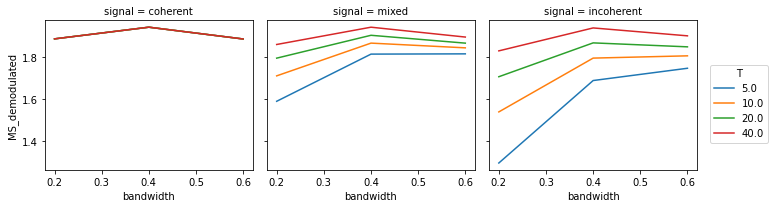

In [43]:
E_hf.MS_demodulated.sel(rms=1).mean('draw').plot(hue='T',col='signal',x='bandwidth')

In [44]:
E_total = (abs(ds_total[['M2_demodulated','MS_demodulated']])**2).mean('time').persist()

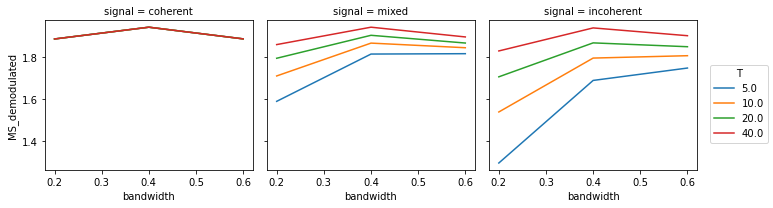

<Figure size 432x288 with 0 Axes>

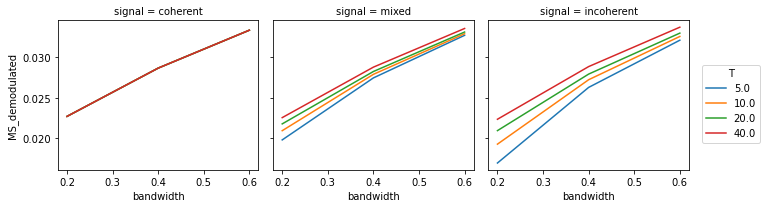

In [47]:
E_total.MS_demodulated.sel(rms=1,T_low=20).mean('draw').plot(hue='T',col='signal',x='bandwidth')
plt.figure()
E_total.MS_demodulated.sel(rms=0.01,T_low=2).mean('draw').plot(hue='T',col='signal',x='bandwidth')

In [62]:
E_hf.to_zarr(root_dir+'E_hf.zarr')

In [63]:
E_total.to_zarr(root_dir+'E_total.zarr')

In [49]:
E_hf = E_hf.compute()
E_hf.to_netcdf(root_dir+'E_hf.nc')

In [50]:
E_total = E_total.compute()

In [51]:
E_total.to_netcdf(root_dir+'E_total.nc')

In [25]:
_ds = ds_filtered_M2.sel(rms=1,T=10).isel(bandwidth=1).mean(['draw'])

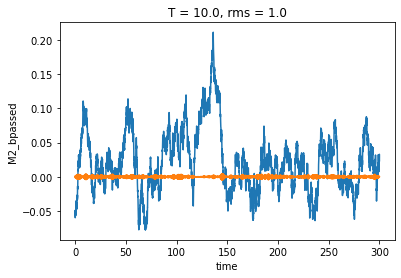

In [27]:
_ds.isel(signal=-1).M2.plot()
_ds.isel(signal=-1).M2_bpassed.real.plot()

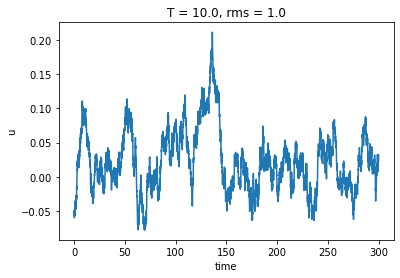

In [33]:
ds_hf['M2'].sel(rms=1,T=10).mean('draw').plot()

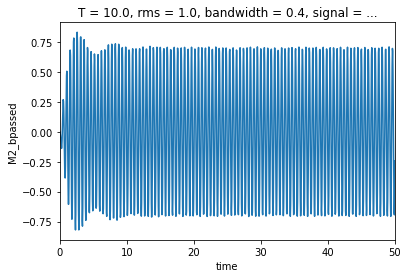

In [80]:
_ds.M2_bpassed.real.sel(signal='mixed').plot(xlim=(0,50))

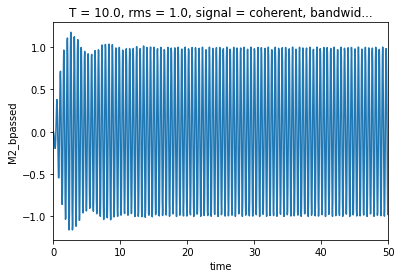

In [74]:
_ds.M2_bpassed.real.plot(xlim=(0,50))

### Lowpass filter

In [166]:
# filter properties:
filter_cutoff = 1 # cpd
filter_size = 20 # in days
filter_size_pts = int(20/dt) # in points

filter_h, filter_t = sigp.lowpass_filter(filter_cutoff, filter_size_pts, dt)
h_hat, w = sigp.filter_response(filter_h, dt)

In [114]:
ds_filtered_M2

<xarray.Dataset>
Dimensions:         (T: 4, draw: 50, time: 7200, rms: 4, bandwidth: 3, signal: 3)
Coordinates:
  * T               (T) float64 5.0 10.0 20.0 40.0
  * draw            (draw) int64 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
  * time            (time) float64 0.0 0.04167 0.08333 ... 299.9 299.9 300.0
  * rms             (rms) float64 0.01 0.1 1.0 2.0
  * bandwidth       (bandwidth) float64 0.2 0.4 0.6
  * signal          (signal) <U10 'coherent' 'mixed' 'incoherent'
Data variables:
    M2              (bandwidth, signal, rms, time, T, draw) float64 0.1 ... 0...
    M2_bpassed      (bandwidth, signal, rms, T, draw, time) complex128 (8.026...
    M2_demodulated  (bandwidth, signal, rms, T, draw, time) complex128 (8.026...
    exp             (bandwidth, signal, time) complex128 (1+0j) ... (-0.80316...
    M2_lpassed      (bandwidth, signal, rms, T, draw, time) float64 8.026e-11...

In [115]:
h_hat

array([ 1.00000000e+00+0.00000000e+00j,  9.95587183e-01-9.39134710e-02j,
        9.82387380e-01-1.87000624e-01j, ...,
       -1.03862863e-10+3.58285762e-10j, -5.44489454e-11+2.86041926e-10j,
       -1.48780432e-11+1.57723654e-10j])

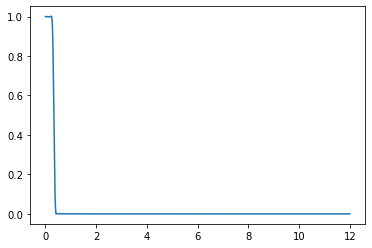

In [112]:
plt.plot(w,abs(h_hat))

In [167]:
ds_filtered_M2["M2_lpassed"] = sigp.filt(ds_filtered_M2.M2_bpassed.real, filter_h)

In [168]:
_ds = ds_filtered_M2.sel(rms=1,bandwidth=0.4,T=10)#.mean(['draw'])

In [156]:
ds_M2

<xarray.DataArray 'time' (signal: 3, rms: 4, time: 7200, T: 4, draw: 50)>
array([[[[[ 1.00000000e-01+0.j        ,  1.00000000e-01+0.j        ,
            1.00000000e-01+0.j        , ...,
            1.00000000e-01+0.j        ,  1.00000000e-01+0.j        ,
            1.00000000e-01+0.j        ],
          [ 1.00000000e-01+0.j        ,  1.00000000e-01+0.j        ,
            1.00000000e-01+0.j        , ...,
            1.00000000e-01+0.j        ,  1.00000000e-01+0.j        ,
            1.00000000e-01+0.j        ],
          [ 1.00000000e-01+0.j        ,  1.00000000e-01+0.j        ,
            1.00000000e-01+0.j        , ...,
            1.00000000e-01+0.j        ,  1.00000000e-01+0.j        ,
            1.00000000e-01+0.j        ],
          [ 1.00000000e-01+0.j        ,  1.00000000e-01+0.j        ,
            1.00000000e-01+0.j        , ...,
            1.00000000e-01+0.j        ,  1.00000000e-01+0.j        ,
            1.00000000e-01+0.j        ]],

         [[ 8.74754176e-02+0.0484567j ,  8.74754176e-02+0.0484567j ,
            8.74754176e-02+0.0484567j , ...,
            8.74754176e-02+0.0484567j ,  8.74754176e-02+0.0484567j ,
...
           -1.28986963e+00+0.j        , ...,
           -3.00113409e+00+0.j        , -8.00910034e-01+0.j        ,
            3.31274616e-01+0.j        ]],

         [[ 3.55583998e-01+0.j        ,  8.80483309e-01+0.j        ,
           -1.37472791e+00+0.j        , ...,
           -4.61566569e-02+0.j        ,  1.49790115e+00+0.j        ,
           -3.27865076e+00+0.j        ],
          [-1.58984880e-01+0.j        ,  1.46454803e+00+0.j        ,
            8.78436048e-01+0.j        , ...,
           -4.10202058e-01+0.j        ,  2.72132785e+00+0.j        ,
           -1.50451064e+00+0.j        ],
          [-9.67566563e-01+0.j        ,  5.86445892e-01+0.j        ,
            2.72180323e+00+0.j        , ...,
           -4.53291637e-01+0.j        , -3.33340314e-01+0.j        ,
            2.07871920e-01+0.j        ],
          [ 2.13868229e+00+0.j        ,  1.08013883e+00+0.j        ,
           -1.28802552e+00+0.j        , ...,
           -2.99831202e+00+0.j        , -8.24366235e-01+0.j        ,
            3.07507340e-01+0.j        ]]]]])
Coordinates:
  * T        (T) float64 5.0 10.0 20.0 40.0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 299.9 299.9 300.0
  * rms      (rms) float64 0.01 0.1 1.0 2.0
  * signal   (signal) <U10 'coherent' 'mixed' 'incoherent'

In [131]:
h_hat.size

8000

In [129]:
_ds.M2_bpassed.real

<xarray.DataArray 'M2_bpassed' (signal: 3, draw: 50, time: 7200)>
array([[[ 3.28967079e-09, -1.76263152e-02, -4.55380194e-02, ...,
         -4.68476122e-01, -2.74524675e-01, -2.64216003e-09],
        [ 3.28967079e-09, -1.76263152e-02, -4.55380194e-02, ...,
         -4.68476122e-01, -2.74524675e-01, -2.64216003e-09],
        [ 3.28967079e-09, -1.76263152e-02, -4.55380194e-02, ...,
         -4.68476122e-01, -2.74524675e-01, -2.64216003e-09],
        ...,
        [ 3.28967079e-09, -1.76263152e-02, -4.55380194e-02, ...,
         -4.68476122e-01, -2.74524675e-01, -2.64216003e-09],
        [ 3.28967079e-09, -1.76263152e-02, -4.55380194e-02, ...,
         -4.68476122e-01, -2.74524675e-01, -2.64216003e-09],
        [ 3.28967079e-09, -1.76263152e-02, -4.55380194e-02, ...,
         -4.68476122e-01, -2.74524675e-01, -2.64216003e-09]],

       [[ 8.91305297e-10, -4.76413682e-03, -1.92553282e-02, ...,
         -3.32311753e-01, -1.94910963e-01, -2.12979355e-09],
        [ 4.92294655e-09,  1.46720461e-02,  1.51345967e-02, ...,
         -3.21029882e-01, -1.88337929e-01,  5.40650831e-10],
        [ 3.04337498e-09,  6.63168396e-03,  1.51153070e-03, ...,
         -3.36964790e-01, -1.97474692e-01, -4.23406763e-10],
...
        [ 2.52657685e-09, -3.45729350e-02, -7.07230603e-02, ...,
         -3.22863466e-01, -1.89296497e-01, -2.54300439e-09],
        [ 1.16645604e-09, -3.21412189e-02, -6.69725463e-02, ...,
         -2.88662908e-01, -1.69702046e-01,  2.60784674e-09],
        [ 3.95137974e-09, -9.26881778e-03, -2.64417006e-02, ...,
         -3.34362111e-01, -1.95746626e-01, -4.34296166e-09]],

       [[-2.02917465e-09,  1.08888083e-02,  1.83068731e-02, ...,
         -1.48366593e-03, -1.12105343e-03, -3.69822436e-10],
        [ 3.67242696e-09,  3.83757218e-02,  6.69415714e-02, ...,
          1.44713093e-02,  8.17462149e-03,  3.40675615e-09],
        [ 1.01431168e-09,  2.70049326e-02,  4.76756467e-02, ...,
         -8.06405308e-03, -4.74671246e-03,  2.04337265e-09],
        ...,
        [ 2.83448534e-10, -3.12671984e-02, -5.44794916e-02, ...,
          1.18782302e-02,  6.81900143e-03, -9.54190868e-10],
        [-1.64005265e-09, -2.78282324e-02, -4.91754639e-02, ...,
          6.02451228e-02,  3.45297392e-02,  6.33021250e-09],
        [ 2.29842415e-09,  4.51822742e-03,  8.14380789e-03, ...,
         -4.38330977e-03, -2.30285902e-03, -3.49971506e-09]]])
Coordinates:
    T          float64 10.0
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 299.9 299.9 300.0
    rms        float64 1.0
    bandwidth  float64 0.4
  * signal     (signal) <U10 'coherent' 'mixed' 'incoherent'

In [132]:
_ = sigp.filt(_ds.M2_bpassed.real, filter_h)

(100.0, 150.0)

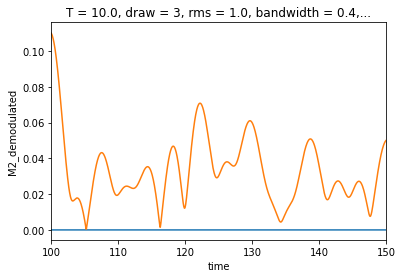

In [170]:
#_ds.sel(signal='incoherent',draw=3).M2.plot()
_ds.sel(signal='incoherent',draw=3).M2_lpassed.real.plot()
abs(_ds.sel(signal='incoherent',draw=3).M2_demodulated).plot()
plt.xlim(100,150)
#_ds.sel(signal='incoherent',draw=3).M2_lpassed.plot()

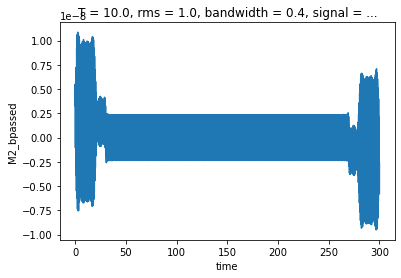

In [128]:
_.mean('draw').sel(signal='coherent').plot()

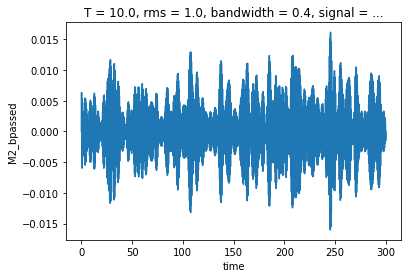

In [97]:
#np.abs(_ds.sel(signal='incoherent').M2_demodulated).plot()
_ds.sel(signal='incoherent').M2_bpassed.real.plot()

In [93]:
np.abs(_ds.sel(signal='incoherent').M2_demodulated**2).mean('time')

<xarray.DataArray 'M2_demodulated' ()>
array(3.48506483e-05)
Coordinates:
    T          float64 10.0
    rms        float64 1.0
    bandwidth  float64 0.4
    signal     <U10 'incoherent'

In [95]:
np.abs(_ds.sel(signal='incoherent').M2_lpassed**2).mean('time')

<xarray.DataArray 'M2_lpassed' ()>
array(2.32605286e-19)
Coordinates:
    T          float64 10.0
    rms        float64 1.0
    bandwidth  float64 0.4
    signal     <U10 'incoherent'

In [10]:
cluster.close()
#client.restart()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
